## Import Modules

In [72]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_selection import RFE

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
pd.set_option('display.max_columns', None)

## Import Data

In [7]:
raw_data = pd.read_csv(r"E:\Legacy Files\Documents\Py-Self-Learn\credit_card_default_prediction\data\UCI_Credit_Card.csv")

In [8]:
raw_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## EDA

In [6]:
# Check for unique value count
raw_data.nunique()

ID                            30000
LIMIT_BAL                        81
SEX                               2
EDUCATION                         7
MARRIAGE                          4
AGE                              56
PAY_0                            11
PAY_2                            11
PAY_3                            11
PAY_4                            11
PAY_5                            10
PAY_6                            10
BILL_AMT1                     22723
BILL_AMT2                     22346
BILL_AMT3                     22026
BILL_AMT4                     21548
BILL_AMT5                     21010
BILL_AMT6                     20604
PAY_AMT1                       7943
PAY_AMT2                       7899
PAY_AMT3                       7518
PAY_AMT4                       6937
PAY_AMT5                       6897
PAY_AMT6                       6939
default.payment.next.month        2
dtype: int64

In [7]:
# Check for missing values
raw_data.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

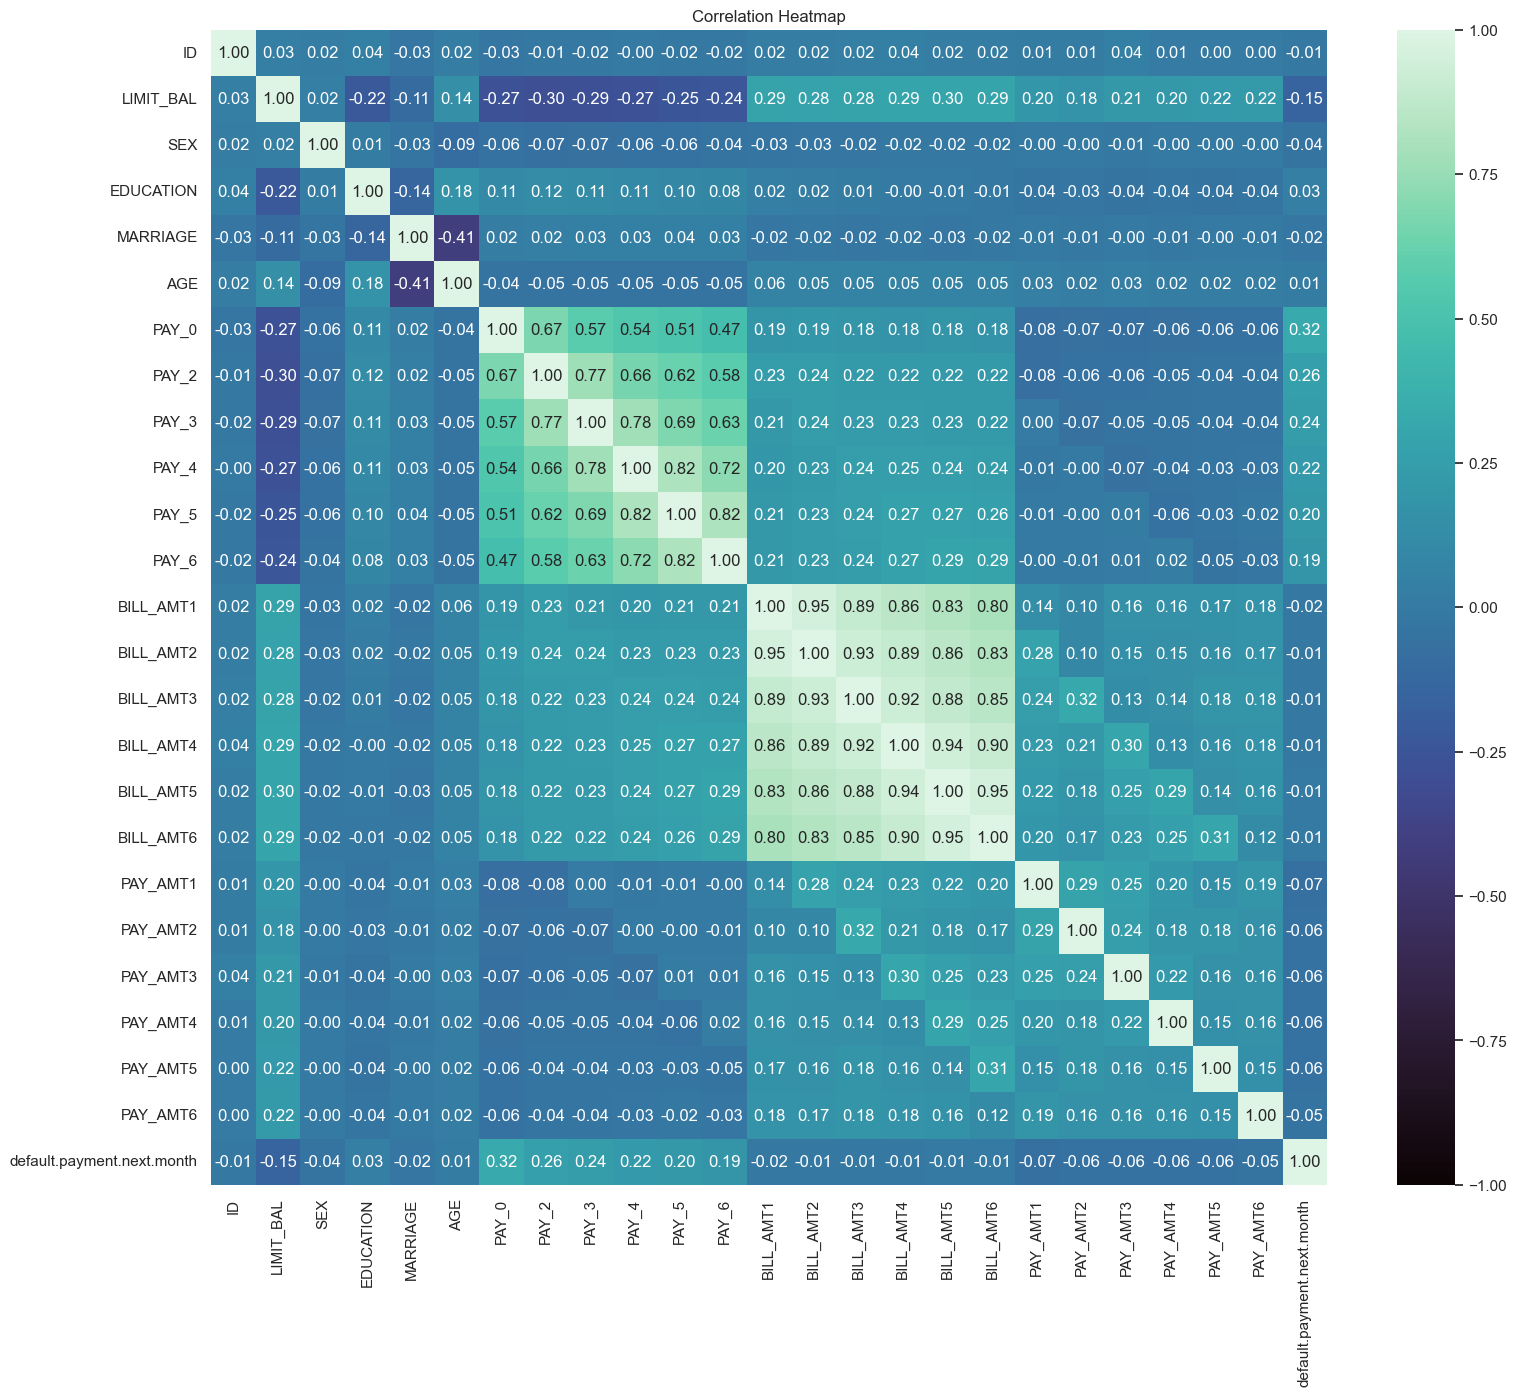

In [8]:
# Check correlation heatmap
corr = raw_data.corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr, annot=True, vmin = -1.0, cmap = 'mako', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Notes:

Bill amounts are highly correlated, we should probably keep just one or use the mean bill amt


In [9]:
data = raw_data.copy()
data = data.drop('ID', axis=1)

In [10]:
# Get categorical and numerical features
categorical_features = [feature for feature in data.columns if data[feature].nunique() < 20 and feature != 'default.payment.next.month']
continuous_features = [feature for feature in data.columns if feature not in categorical_features and feature != 'default.payment.next.month']

In [11]:
len(continuous_features)

14

In [19]:
str(data['BILL_AMT1'].dtype)

'float64'

Text(0.5, 1.0, 'Histogram Plot')

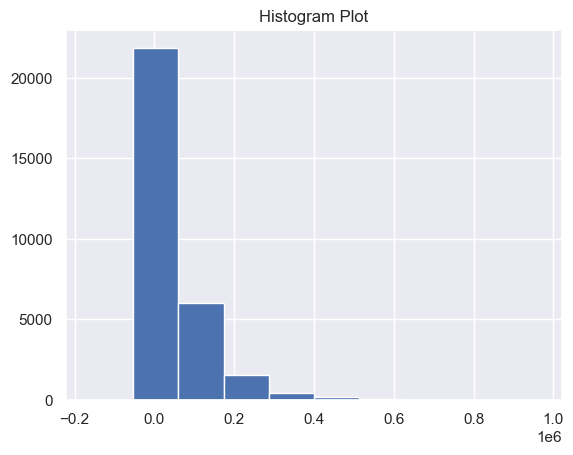

In [113]:
# Statistical Visualizaions
plt.figure()
plt.hist(data['BILL_AMT1'])
plt.title('Histogram Plot')



## Preprocessing & Feature Engineering

In [164]:
data = raw_data.copy()
data = data.drop('ID', axis=1)

In [165]:
# Merge bill amounts 

data['total_bill'] = (data['BILL_AMT1'] + data['BILL_AMT2'] + data['BILL_AMT3'] + data['BILL_AMT4'] + data['BILL_AMT5'] + data['BILL_AMT6'])
data['total_paid'] = (data['PAY_AMT1'] + data['PAY_AMT2'] + data['PAY_AMT3'] + data['PAY_AMT4'] + data['PAY_AMT5'] + data['PAY_AMT6'])
data['total_outstanding'] = data['total_bill'] - data['total_paid']

data['out_1'] = data['BILL_AMT1'] - data['PAY_AMT1']
data['out_2'] = data['BILL_AMT2'] - data['PAY_AMT2']
data['out_3'] = data['BILL_AMT3'] - data['PAY_AMT3']
data['out_4'] = data['BILL_AMT4'] - data['PAY_AMT4']
data['out_5'] = data['BILL_AMT5'] - data['PAY_AMT5']
data['out_6'] = data['BILL_AMT6'] - data['PAY_AMT6']

data['still_owed_ratio'] = data['total_paid']/data['LIMIT_BAL']

# Use log of limit bal
# data['LIMIT_BAL'] = np.log(data['LIMIT_BAL'])

data = data.drop(['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], axis=1)

new_cols_arrangement = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
                        'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                        'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'total_bill', 'total_paid', 'total_outstanding',
                        'out_1', 'out_2', 'out_3', 'out_4', 'out_5', 'out_6', 'still_owed_ratio', 'default.payment.next.month'
                        ]
data = data[new_cols_arrangement]

In [166]:
data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,total_bill,total_paid,total_outstanding,out_1,out_2,out_3,out_4,out_5,out_6,still_owed_ratio,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,0.0,689.0,0.0,0.0,0.0,0.0,7704.0,689.0,7015.0,3913.0,2413.0,689.0,0.0,0.0,0.0,0.034450,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,0.0,1000.0,1000.0,1000.0,0.0,2000.0,17077.0,5000.0,12077.0,2682.0,725.0,1682.0,2272.0,3455.0,1261.0,0.041667,1
2,90000.0,2,2,2,34,0,0,0,0,0,0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,101653.0,11018.0,90635.0,27721.0,12527.0,12559.0,13331.0,13948.0,10549.0,0.122422,0
3,50000.0,2,2,1,37,0,0,0,0,0,0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,231334.0,8388.0,222946.0,44990.0,46214.0,48091.0,27214.0,27890.0,28547.0,0.167760,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,109339.0,59049.0,50290.0,6617.0,-31011.0,25835.0,11940.0,18457.0,18452.0,1.180980,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,3,1,39,0,0,0,0,0,0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,725349.0,42550.0,682799.0,180448.0,172815.0,203362.0,84957.0,26237.0,14980.0,0.193409,0
29996,150000.0,1,3,2,43,-1,-1,-1,-1,0,0,1837.0,3526.0,8998.0,129.0,0.0,0.0,21182.0,14490.0,6692.0,-154.0,-1698.0,-5496.0,8850.0,5190.0,0.0,0.096600,0
29997,30000.0,1,2,2,37,4,3,2,-1,0,0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,70496.0,31300.0,39196.0,3565.0,3356.0,-19242.0,16678.0,18582.0,16257.0,1.043333,1
29998,80000.0,1,3,1,41,1,-1,0,0,0,-1,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,266611.0,147181.0,119430.0,-87545.0,74970.0,75126.0,50848.0,-41109.0,47140.0,1.839762,1


In [167]:
data['avg_bill']

KeyError: 'avg_bill'

In [168]:
# Get categorical and numerical features
categorical_features = [feature for feature in data.columns if data[feature].nunique() < 20 and feature != 'default.payment.next.month']
continuous_features = [feature for feature in data.columns if feature not in categorical_features and feature != 'default.payment.next.month']

Encode categorical features

In [169]:
data_temp = data.copy()
data_to_encode = data_temp[categorical_features]

# Initialize and fit encoder 
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoder.fit(data_to_encode)

# Transform data
encoded_columns = encoder.transform(data_to_encode)
encoded_df = pd.DataFrame(encoded_columns, 
                          columns=encoder.get_feature_names_out(categorical_features))

data_temp.drop(categorical_features, axis=1, inplace=True)
data_encoded = pd.concat([data_temp, encoded_df], axis=1)

In [170]:
data_encoded.columns

Index(['LIMIT_BAL', 'AGE', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
       'PAY_AMT5', 'PAY_AMT6', 'total_bill', 'total_paid', 'total_outstanding',
       'out_1', 'out_2', 'out_3', 'out_4', 'out_5', 'out_6',
       'still_owed_ratio', 'default.payment.next.month', 'SEX_2',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'EDUCATION_6', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3',
       'PAY_0_-1', 'PAY_0_0', 'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4',
       'PAY_0_5', 'PAY_0_6', 'PAY_0_7', 'PAY_0_8', 'PAY_2_-1', 'PAY_2_0',
       'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6',
       'PAY_2_7', 'PAY_2_8', 'PAY_3_-1', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2',
       'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8',
       'PAY_4_-1', 'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3', 'PAY_4_4',
       'PAY_4_5', 'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_-1', 'PAY_5_0',
       'PAY_5_2', 'PAY_5_3', 'PAY_5_4', 'PAY_5_5', 'PAY_

Undersample the data

In [171]:
# Undersample any target label with count > mean count of the dataset

def undersample_by_value_counts(data, label_column):
    value_counts = data[label_column].value_counts()
    mean_count = value_counts.mean()

    undersampled_data = pd.DataFrame(columns=data.columns)

    for value, count in value_counts.items():
        if count > mean_count:
            undersampled_count = int((count / value_counts.sum()) * (mean_count/2))
            subset = data[data[label_column] == value].sample(n=undersampled_count, random_state=42)
            undersampled_data = pd.concat([undersampled_data, subset], ignore_index=True)
        else:
            subset = data[data[label_column] == value]
            undersampled_data = pd.concat([undersampled_data, subset], ignore_index=True)

    # Randomize the undersampled data
    randomized_data = undersampled_data.sample(frac=1, random_state=42)

    return randomized_data.astype('int64')

In [172]:
undersampled_data = undersample_by_value_counts(data, 'default.payment.next.month')

In [173]:
undersampled_data_encoded = undersample_by_value_counts(data_encoded, 'default.payment.next.month')

In [174]:
undersampled_data['default.payment.next.month'].value_counts()

1    6636
0    5841
Name: default.payment.next.month, dtype: int64

## Model Experiments

### Train-Test Split

In [175]:
# select data to split
data_used = undersampled_data_encoded

X = data_used.drop('default.payment.next.month', axis=1) # Inputs
y = data_used['default.payment.next.month'] # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y,
                                                    shuffle=True)

### Scale the Inputs

In [176]:
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [177]:
X_train_scaled.shape

(9981, 86)

### Feature Selection - Recursive Feature Elimination

Setup Baseline Model - Gradient Boosting Classifier

In [178]:
# Classification Report for default classes
def print_f1_scores(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)

    for class_label, metric in report.items():
        try:
            f1_score_float = metric['f1-score']
            print(f"Class {class_label}: F1-score = {round(f1_score_float, 3)}")
        except:
            pass

In [179]:
# Initialize classifier
gbc = GradientBoostingClassifier(random_state=42)

# Train classifier using all features
gbc.fit(X_train_scaled, y_train)

# Make predictions
preds = gbc.predict(X_test_scaled)

# Evaluate model (F1 Score)
print_f1_scores(y_test, preds)

Class 0: F1-score = 0.704
Class 1: F1-score = 0.703
Class macro avg: F1-score = 0.704
Class weighted avg: F1-score = 0.703


Setup RFE Feature Selector

In [50]:
f1_score_list_weighted = []
f1_score_list_macro = []

for k in range(10,81,10):
    RFE_selector = RFE(estimator=gbc, n_features_to_select=k, step=5)
    RFE_selector.fit(X_train_scaled, y_train)

    sel_X_train = RFE_selector.transform(X_train_scaled)
    sel_X_test = RFE_selector.transform(X_test_scaled)

    gbc.fit(sel_X_train, y_train)
    RFE_preds = gbc.predict(sel_X_test)

    f1_score_rfe_weighted = round(f1_score(y_test, RFE_preds, average='weighted'), 3)
    f1_score_rfe_macro = round(f1_score(y_test, RFE_preds, average='macro'), 3)
    f1_score_list_weighted.append(f1_score_rfe_weighted)
    f1_score_list_macro.append(f1_score_rfe_macro)

    print(f"Class scores for {k} features model:")
    print_f1_scores(y_test, RFE_preds)
    print('##----------------------------------------##\n')

Class scores for 10 features model:
Class 0: F1-score = 0.698
Class 1: F1-score = 0.699
Class macro avg: F1-score = 0.698
Class weighted avg: F1-score = 0.698
##----------------------------------------##

Class scores for 20 features model:
Class 0: F1-score = 0.707
Class 1: F1-score = 0.7
Class macro avg: F1-score = 0.703
Class weighted avg: F1-score = 0.703
##----------------------------------------##

Class scores for 30 features model:
Class 0: F1-score = 0.71
Class 1: F1-score = 0.705
Class macro avg: F1-score = 0.708
Class weighted avg: F1-score = 0.707
##----------------------------------------##

Class scores for 40 features model:
Class 0: F1-score = 0.714
Class 1: F1-score = 0.71
Class macro avg: F1-score = 0.712
Class weighted avg: F1-score = 0.712
##----------------------------------------##

Class scores for 50 features model:
Class 0: F1-score = 0.713
Class 1: F1-score = 0.71
Class macro avg: F1-score = 0.711
Class weighted avg: F1-score = 0.711
##------------------------

In [49]:
list(range(10,81,10))

[10, 20, 30, 40, 50, 60, 70, 80]

In [73]:
models = {
    LogisticRegression(): 'Logistic Regression',
    SVC(): 'C-Support Vector Classification',
    MLPClassifier(): 'Neural Network (Multi-layer Perceptron classifier)',
    RandomForestClassifier(): 'Random Forest',
    DecisionTreeClassifier(): 'Decision Tree',
    }

for model in models.keys():
    model.fit(X_train_scaled, y_train)


e:\Legacy Files\Documents\Py-Self-Learn\credit_card_default_prediction\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [74]:
for model, name in models.items():
    y_true = y_test.copy()
    y_pred = model.predict(X_test_scaled)
    
    accuracy = model.score(X_test_scaled, y_test)
    F1_SCORE = f1_score(y_true, y_pred, average='macro')
    
    print(f"{name}: \naccuracy --> {accuracy}\nf1_score --> {F1_SCORE}\n")

Logistic Regression: 
accuracy --> 0.688301282051282
f1_score --> 0.6872311433955578

C-Support Vector Classification: 
accuracy --> 0.6967147435897436
f1_score --> 0.696135255989135

Neural Network (Multi-layer Perceptron classifier): 
accuracy --> 0.6919070512820513
f1_score --> 0.6919066062044554

Random Forest: 
accuracy --> 0.7047275641025641
f1_score --> 0.7047237250468906

Decision Tree: 
accuracy --> 0.6109775641025641
f1_score --> 0.610030560491285

XGB Classifier: 
accuracy --> 0.6830929487179487
f1_score --> 0.6828909258153688



In [69]:
model_params = {
    # 'Logistic Regression': {
    #     'model': LogisticRegression(),
    #     'params': {
    #         'C': list(range(1,30,9)),
    #         'solver': ['liblinear', 'newton-cg']
    #     }
    # },
    
    # 'C-Support Vector Classification': {
    #     'model': SVC(),
    #     'params': {
    #         'C': list(range(1,20,10)),
    #         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #         'gamma': ['scale', 'auto']
    #     }
    # },
    
    # 'Neural Network (Multi-layer Perceptron classifier)': {
    #     'model': MLPClassifier(),
    #     'params': {
    #         'hidden_layer_sizes': list(range(100,450,200)),
    #         'activation': ['identity', 'logistic', 'tanh', 'relu'],
    #         'solver': ['lbfgs', 'sgd', 'adam'],
    #         # 'max_iter': list(range(200,450,100))
    #     }
    # },
    
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_features': ["sqrt", "log2", None]
        }
    }
}

In [70]:
scores = []

for model_name, mp in model_params.items():
    run = GridSearchCV(mp['model'], mp['params'], return_train_score=False, n_jobs=-1, scoring = 'f1', verbose = 3, cv=2)
    run.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': run.best_score_,
        'best_params': run.best_params_
    })

Fitting 2 folds for each of 9 candidates, totalling 18 fits


In [71]:
scores

[{'model': 'Random Forest',
  'best_score': 0.7038118298103264,
  'best_params': {'criterion': 'entropy', 'max_features': 'log2'}}]

In [46]:
import os
os.getcwd()

'c:\\Users\\Abraham Audu\\Documents\\Py-Self-Learn\\credit_card_default_prediction\\experiments'

### Preprocessing Functions

In [ ]:
from pandas import DataFrame

def get_categotical_features(data: DataFrame, train: bool):
    """_summary_

    Args:
        data (DataFrame): _description_
        train (bool): _description_

    Returns:
        _type_: _description_
    """

    cat_featutes_path = "./models/cat_features.pkl"

    if train:
        # Get categorical features
        categorical_features = [feature for feature in data.columns if data[feature].nunique() < 20\
                                and feature != 'default.payment.next.month']
        # Save categorical features
        joblib.dump(categorical_features, cat_featutes_path)

    else:
        # Load categorical features
        categorical_features = joblib.load(cat_featutes_path)

    return categorical_features


In [ ]:
def fit_encoder(data: DataFrame, categorical_features: list, train: bool):
    """_summary_

    Args:
        data (DataFrame): _description_
        categorical_features (list): _description_
        train (bool): _description_

    Returns:
        _type_: _description_
    """

    # Set encoder path
    encoder_path = "./models/encoder.pkl"

    # Get categotical features
    data_to_transform = data[categorical_features]

    if train:
        # Initialize and fit encoder 
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        encoder.fit(data_to_transform)

        # Save encoder
        joblib.dump(encoder, encoder_path)
        logger.info("Encoder saved successfully")

    return data_to_transform     


In [ ]:
def transform_data(data: DataFrame,
                   data_to_transform: DataFrame,
                   categorical_features: list):
    """_summary_

    Args:
        data (DataFrame): _description_
        data_to_encode (DataFrame): _description_
        categorical_features (list): _description_

    Returns:
        _type_: _description_
    """

    # Set encoder path
    encoder_path = "./models/encoder.pkl"

    # Load encoder
    encoder = joblib.load(encoder_path)

    # Transform data with encoder
    encoded_columns = encoder.transform(data_to_transform)
    encoded_df = pd.DataFrame(encoded_columns, 
                            columns=encoder.get_feature_names_out(categorical_features))
    # Remove old versions of encoded columns
    data.drop(categorical_features, axis=1, inplace=True)
    data_transformed = pd.concat([data, encoded_df], axis=1)

    return data_transformed

In [ ]:
def scale_data(features: DataFrame, train: bool):
    """_summary_

    Args:
        features (DataFrame): _description_
        train (bool): _description_

    Returns:
        _type_: _description_
    """

    # Set scaler path
    scaler_path = f"./models/scaler.pkl"

    if train:
        # Fit scaler to features
        scaler = StandardScaler().fit(features)

        # Save scaler
        joblib.dump(scaler, scaler_path)
        logger.info("Scaler saved successfully")

        # Scale train features
        features_scaled = scaler.transform(features)
        logger.info("features scaled successfully")

    else:
        # Load scaler
        scaler = joblib.load(scaler_path)

        # Scale inference features
        features_scaled = scaler.transform(features)
        logger.info("features scaled successfully")

    return features_scaled